# HERORY

This is the HERORY notebook with trainings, results and evaluations 

## Shrinking dataset

As the kaggle fairy tale dataset is too large, we shrink down the original dataset in the following cell:

In [1]:
shrink_line = 19686

lines_to_write = []

with open('./datasets/merged_clean.txt', 'r') as rf:
    index = 1
    for line in rf:
        if index == shrink_line:
            break
        
        index += 1
        lines_to_write.append(line)
        
    rf.close()
    
with open('./datasets/merged_clean_shrinked.txt', 'w') as wf:
    for line in lines_to_write:
        wf.write(line)
    wf.close()

## Loading word dictionary

There are two ways to load the word dictionary into the HERORY tokenizer

Choose one below:

1. load word dictionary from dataset
2. load existing word dictionary from file (containing word dictionary)

In [2]:
# import necessary packages
from herory.data import Tokenizer, FileLoader

In [3]:
# 1
# load word dictionary from dataset

# initialize tokenizer [optional]
tokenizer = Tokenizer()

# load dataset with tokenizer and file loader
fl = FileLoader(tokenizer=tokenizer, path='./datasets/merged_clean_shrinked.txt')

# load word dictionary from dataset
fl.load_dict()

# save word dictionary [optional]
fl.save_dict(path='./datasets/dict_shrinked.json')

Reading file at ./datasets/merged_clean_shrinked.txt ...
Writing word dictionary to ./datasets/dict_shrinked.json ...


In [2]:
# 2
# load existing word dictionary

# initialize tokenizer [optional]
tokenizer = Tokenizer()

# load word dictionary into tokenizer with fileloader
fl = FileLoader(tokenizer=tokenizer) # or fl = FileLoader()

# load existing word dictionary
fl.load_exist_dict(path='./datasets/dict_shrinked.json')

Loading existing word dictionary from ./datasets/dict_shrinked.json ...


## Model Training

### Detecting cuda

In [8]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)

Device:  cuda


### Defining dataset and dataloader

In [4]:
from herory.data import StoryByStoryDataset
from torch.utils.data import DataLoader

# sequence length
sequence_length = 128

# initialize dataset
dataset = StoryByStoryDataset(
    tokenizer=tokenizer, 
    sequence_length=sequence_length, 
    path='./datasets/merged_clean_shrinked.txt'
    )

# batch size of dataloader
batch_size = 32

# torch dataloader
dataloader = DataLoader(dataset, batch_size=batch_size)

Initializing dataset ...


### Defining model

The model for HERORY is an unidirectional LSTM model.

In [11]:
from herory.model import LSTM

num_vocab = dataset.get_num_vocab()
embedding_dim = 128
num_layers = 2
hidden_size = 128
dropout_rate = 0.1

# model (LSTM)
lstm = LSTM(
    num_vocab=num_vocab,
    hidden_size=hidden_size,
    embedding_dim=embedding_dim,
    num_layers=num_layers,
    dropout=dropout_rate,
    device=device
    )

print(lstm)

LSTM(
  (embedding): Embedding(7609, 128)
  (lstm): LSTM(128, 128, num_layers=2, dropout=0.1)
  (fc): Linear(in_features=128, out_features=7609, bias=True)
)


### Defining hyper-parameters

In [9]:
from torch import nn, optim

# number of epochs
num_epochs = 230

# learning rate
learning_rate = 0.000001

# torch criterion
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate)

# probability of masking a word
masking_prob = 0.1

# gradient clipping value, range: [-clipping_value, clipping_value]
clipping_value = 1

# checkpoint save point
epoch_save_point = 10

#### First time training

If you are training the model for the first time, run the 2 following cells

In [16]:
# last epoch the model is trained on, untrained: 0
last_epoch = 0

# checkpoints saving directory
checkpoints_dir = './saves/lstm/'

In [ ]:
# create the saving directory if not exist
!mkdir -p saves/lstm/

## Model Training

By using method implemented in HERORY package, each checkpoint during training will be automatically saved.

In [10]:
from herory.model import train_lstm_with_masking

# training with masking
history = train_lstm_with_masking(
    lstm, 
    dataloader=dataloader, 
    criterion=criterion, 
    optimizer=optimizer, 
    sequence_length=sequence_length,
    epochs=num_epochs,
    device=device,
    masking_prob=masking_prob,
    clipping_value=clipping_value,
    last_epoch=last_epoch,
    checkpoints_dir=checkpoints_dir,
    epoch_save_point=epoch_save_point,
    )

{'epoch': 270, 'batch': 0, 'loss': 4.050684928894043, 'epoch_progress[%]': 0}
{'epoch': 270, 'batch': 1000, 'loss': 4.814747333526611, 'epoch_progress[%]': 14}
{'epoch': 270, 'batch': 2000, 'loss': 4.4990105628967285, 'epoch_progress[%]': 28}
{'epoch': 270, 'batch': 3000, 'loss': 4.243429183959961, 'epoch_progress[%]': 42}
{'epoch': 270, 'batch': 4000, 'loss': 4.437617301940918, 'epoch_progress[%]': 56}
{'epoch': 270, 'batch': 5000, 'loss': 3.979775905609131, 'epoch_progress[%]': 70}
{'epoch': 270, 'batch': 6000, 'loss': 4.332789897918701, 'epoch_progress[%]': 84}
{'epoch': 270, 'batch': 7000, 'loss': 4.602543830871582, 'epoch_progress[%]': 98}
{'epoch': 271, 'batch': 0, 'loss': 4.076415538787842, 'epoch_progress[%]': 0}
{'epoch': 271, 'batch': 1000, 'loss': 4.809077739715576, 'epoch_progress[%]': 14}
{'epoch': 271, 'batch': 2000, 'loss': 4.4966864585876465, 'epoch_progress[%]': 28}
{'epoch': 271, 'batch': 3000, 'loss': 4.245432376861572, 'epoch_progress[%]': 42}
{'epoch': 271, 'batch'

## Saving model and parameters

In [21]:
# create saves directory if not exist
!mkdir -p saves/lstm

mkdir: cannot create directory ‘saves’: File exists
mkdir: cannot create directory ‘saves/lstm’: File exists


In [21]:
from herory.model import save_model_parameters

# save model
torch.save(lstm.state_dict(), './saves/lstm/lastest.pth')

# save model parameters
save_model_parameters(
    num_vocab=num_vocab, 
    hidden_size=hidden_size, 
    embedding_dim=embedding_dim, 
    num_layers=num_layers, 
    dropout=dropout_rate, 
    last_epoch=history['last_epoch'],
    checkpoints_dir=checkpoints_dir,
    path="./saves/lstm/parameters.json"
    )

# save tokenized word dictionary
fl.save_dict(path='./saves/lstm/word_dict.json')

Writing word dictionary to ./saves/lstm/word_dict.json ...


In [12]:
# compress folder to download
!tar -zcvf ./saves/lstm.tar.gz ./saves/lstm

./saves/lstm/
./saves/lstm/89-avg_losses.pt
./saves/lstm/119-avg_losses.pt
./saves/lstm/49-losses.pt
./saves/lstm/19-checkpoint.pth
./saves/lstm/109-losses.pt
./saves/lstm/89-losses.pt
./saves/lstm/69-avg_losses.pt
./saves/lstm/9-checkpoint.pth
./saves/lstm/39-losses.pt
./saves/lstm/19-avg_losses.pt
./saves/lstm/69-losses.pt
./saves/lstm/39-checkpoint.pth
./saves/lstm/29-checkpoint.pth
./saves/lstm/9-avg_losses.pt
./saves/lstm/9-losses.pt
./saves/lstm/39-avg_losses.pt
./saves/lstm/19-losses.pt
./saves/lstm/49-avg_losses.pt
./saves/lstm/29-avg_losses.pt
./saves/lstm/49-checkpoint.pth
./saves/lstm/parameters.json
./saves/lstm/59-avg_losses.pt
./saves/lstm/59-checkpoint.pth
./saves/lstm/79-losses.pt
./saves/lstm/99-losses.pt
./saves/lstm/89-checkpoint.pth
./saves/lstm/79-avg_losses.pt
./saves/lstm/69-checkpoint.pth
./saves/lstm/word_dict.json
./saves/lstm/119-checkpoint.pth
./saves/lstm/29-losses.pt
./saves/lstm/99-avg_losses.pt
./saves/lstm/109-avg_losses.pt
./saves/lstm/99-checkpoint.pt

## Loading model

In [1]:
import torch
from herory.model import LSTM, get_model_parameters
from herory.data import Tokenizer, FileLoader
from torch import optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# initialize tokenizer
tokenizer = Tokenizer()

# initialize file folder
fl = FileLoader(tokenizer=tokenizer)

# load word dictionary to tokenizer
fl.load_exist_dict(path='./saves/lstm/word_dict.json')

# load model parameters
parameters = get_model_parameters(path="./saves/lstm/parameters.json")

# initialize model (LSTM)
lstm = LSTM(
    num_vocab=parameters['num_vocab'],
    hidden_size=parameters['hidden_size'],
    embedding_dim=parameters['embedding_dim'],
    num_layers=parameters['num_layers'],
    device=device
    )

# load model
lstm.load_state_dict(torch.load('./saves/lstm/lastest.pth'))

last_epoch = parameters['last_epoch']
checkpoints_dir = parameters['checkpoints_dir']

C:\Users\Joak\anaconda3\envs\comp3362gp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading existing word dictionary from ./saves/lstm/word_dict.json ...


# GPT-Neo Model Transfer Learning

__Since training from scratch of GPT-Neo model requires too much gpu power, we decided to perform transfer learning the pretrained GPT-Neo model with the shrinked dataset.__

To make the code for training clearer, we use the happytransformer package to train the GPT-Neo model from HuggingFace. Also, note than the GPT-Neo with 1.3B parameters required more than 11GB of varm with training on GPU farm, we down-sized the GPT-Neo model to the 125M parameters one.

## Downloading the model

In [13]:
from happytransformer import HappyGeneration

# 125M parameters GPT-Neo model from HuggingFace
# https://huggingface.co/EleutherAI/gpt-neo-125M
happy_gen = HappyGeneration("GPT-NEO", "EleutherAI/gpt-neo-125M")

04/21/2022 17:48:37 - INFO - happytransformer.happy_transformer -   Using model: cuda


## Example output with the pretrained GPT model

In [14]:
from happytransformer import GENSettings

# text generation settings
generic_sampling_settings = GENSettings(do_sample=True, top_k=0, temperature=0.9,  max_length=200)

In [15]:
text_input = 'Three little pigs'

In [16]:
output_generic_sampling = happy_gen.generate_text(text_input, args=generic_sampling_settings)
print(text_input + output_generic_sampling.text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Three little pigs better come in to help. You’re not a pig! So you can thank your listening gear maker for providing some of the best tools and bins in the world around. As always, we have the largest selection of pigs and they truly are the best in the least amount of time (!) to search, clean, and segue into your wooden piggy home. If you are a first-time visitor, we also provide all the best plastic and woody tools and bins to help you put your home in great shape.

Be Careful To Never Drag Your Dog Out of the Easy Fence, “She’s Always Near You,” in New York Magazine.

Plus, the pig in your home is always at your disposal. The Dog Care Tools store is more than a dog ikey shop

For the most comprehensive information about using the closed-circuit television shows for dog sleep, watch our video guide on The Pomeranian Dog


## Training on our dataset

In [2]:
from happytransformer import GENTrainArgs

num_epochs = 100

learning_rate = 0.001

args = GENTrainArgs(learning_rate=learning_rate, num_train_epochs=num_epochs)

In [3]:
happy_gen.train("./datasets/merged_clean_shrinked.txt", args=args)

04/10/2022 14:31:29 - INFO - happytransformer.happy_transformer -   Preprocessing dataset...
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 351.25it/s]
04/10/2022 14:31:30 - INFO - happytransformer.happy_transformer -   Training...
/userhome/cs/u3560667/anaconda3/envs/comp3362/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 368
  Num Epochs = 100
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 36800


Step,Training Loss
500,3.670200
1000,2.805000
1500,2.055500
2000,1.301400
2500,0.895200
3000,0.581400
3500,0.401100
4000,0.326100
4500,0.249400
5000,0.214300




Training completed. Do not forget to share your model on huggingface.co/models =)




## Saving model

In [4]:
happy_gen.save("./saves/gpt-neo")

Configuration saved in ./saves/gpt-neo/config.json
Model weights saved in ./saves/gpt-neo/pytorch_model.bin
tokenizer config file saved in ./saves/gpt-neo/tokenizer_config.json
Special tokens file saved in ./saves/gpt-neo/special_tokens_map.json


In [ ]:
# compress the gpt-neo model
!tar -zcvf ./saves/gpt-neo.tar.gz ./saves/gpt-neo

## Loading model

In [10]:
from happytransformer import HappyGeneration

generator = HappyGeneration(load_path="./saves/gpt-neo")

04/21/2022 20:23:07 - INFO - happytransformer.happy_transformer -   Using model: cuda


# Evaluation and results

## Losses for HERORY model

In [28]:
import os

losses_files = []
avg_losses_files = []

for file in os.listdir('./saves/lstm'):
    if file.split('-')[-1] == 'losses.pt':
        losses_files.append((int(file.split('-')[0]), file))
    if file.split('-')[-1] == 'avg_losses.pt':
        avg_losses_files.append((int(file.split('-')[0]), file))

losses_files.sort()
avg_losses_files.sort()

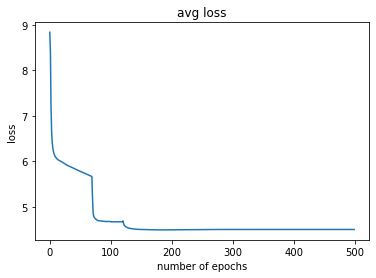

In [32]:
import matplotlib.pyplot as plt
import os

avg_losses = []
for _, file in avg_losses_files:
    avg_losses += torch.load(os.path.join(checkpoints_dir, file))

plt.title('avg loss')
plt.plot(avg_losses)
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.show()

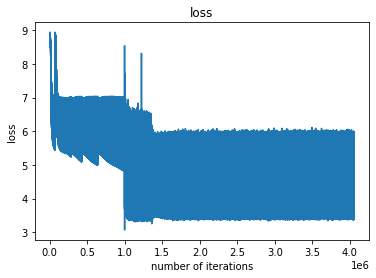

In [31]:
import matplotlib.pyplot as plt
import os

losses = []
for _, file in losses_files:
    losses += torch.load(os.path.join(checkpoints_dir, file))

plt.title('loss')
plt.plot(losses)
plt.xlabel('number of iterations')
plt.ylabel('loss')
plt.show()

## Text generation results

In [3]:
input_text = 'Three little pigs'

### HERORY model

In [12]:
import numpy as np
import torch.nn.functional as F
import time

def predict(model, tokenizer, text, device='cpu', max_length=None):
    start = time.time()
    
    model.to(device)
    model.eval()

    input_seq = tokenizer.text_to_sequence(text)
    state_h, state_c = model.init_state(len(input_seq))

    index = 0
    while input_seq[-1] != tokenizer.get_end_token_index():
        x = torch.tensor([input_seq[index:]]).to(device)
        y_pred, (state_h, state_c) = model(x, (state_h, state_c))

        last_word_logits = y_pred[0][-1]
        p = F.softmax(last_word_logits, dim=0).detach().cpu().numpy()
        word_index = np.random.choice(len(last_word_logits), p=p)
        input_seq.append(word_index)
        
        if max_length !=None and index >= max_length:
            break
        
        index += 1

    time_taken = time.time() - start
    return tokenizer.sequence_to_text(input_seq), time_taken

res_lstm = predict(lstm, tokenizer, input_text, device=device, max_length=200)

print(res_lstm[0])

three little pigs for them severely , ' let me teach your kingdom ! ' said the king . ' but i come upon some more in the tanuki against my legs of us i can go , ' answered the bear , and went to ride place , laufer slept thinking to life himself , as fast as night as hers as before . in the way was put to hear and everybody , to lose the little distance , the grander from this time . as all the boy put to be vengeance and so much hunt . the sacrifice was just jumped within out to buy the birds ' s mouth . this was to courts them darted , but when one day it fell a day the finest stretched the wind and did not feel across some of their bidding manner for . ' then tell you something a child . ' the castle together , and make the rocks which his heart did not mind on his pocket , which is as made was astonished after he noticed that wondering what did , so fast there for satisfaction , then she was out a shirt was only dragged ?


### GPT-Neo model

In [13]:
from happytransformer import GENSettings
import time

def gen_text(text):
    start = time.time()
    
    # text generation settings
    generic_sampling_settings = GENSettings(do_sample=True, top_k=0, temperature=0.9,  max_length=200)

    output_generic_sampling = generator.generate_text(text, args=generic_sampling_settings)
    
    time_taken = time.time() - start
    return input_text + output_generic_sampling.text, time_taken

res_gpt = gen_text(input_text)

print(res_gpt[0])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Three little pigs have been killed by thecats, and six of the pieces lean visibly.NOTE 11. This is certainly a exaggerated troop ofmagical bones.NOTE 12. In my original, the coat of which is made into a robe, I havefound it to be worn under the present.NOTE 13. This is the only guess in the original that all this is said to have been done bythis merchant; but, by Allah, no one in the present series of tales of aordordine and any of the higher rank of the noble tongue, being a famous collection ofgood men, is madly fond of carrying accordions and verses, and especiallythe wives of Kings.NOTE 14. In the original, the coat of a person of rank is made ofcloth, with sleeves of bright leather, and a long outer covering of silkinterlarded with gold.NOTE 15.--_On Marriage._ This story is not in the old version; but I havesubstitively considered it


### Text generation difference
Since GPT-Neo model has 125 million parameters, the text generation time is much long than the LSTM model

In [15]:
time_diff = res_gpt[1] - res_lstm[1]

print('text generation time difference: ', time_diff, 's')

text generation time difference:  1.7647109031677246 s


# Other models

### Encoder-decoder LSTM model

sequence-to-sequence model with attention mechanism

In [ ]:
from herory.model import AttnSeq2SeqLSTM
import torch

num_vocab = dataset.get_num_vocab()
hidden_size = 128
embedding_dim = 128
dropout = 0.4
ratio = 0.5

model = AttnSeq2SeqLSTM(
    num_vocab=num_vocab, 
    embedding_dim=embedding_dim, 
    hidden_size=hidden_size, 
    dropout=dropout,
    device=device,
    teacher_force_ratio=ratio
    )

In [ ]:
from torch import nn, optim

# number of epochs
num_epochs=100

# learning rate
learning_rate=0.02

# criterion
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.get_padding_token_index())

# optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# probability of masking a word
masking_prob = 0.1

# gradient clipping value, range: [-clipping_value, clipping_value]
clipping_value = 1

# checkpoint save point
epoch_save_point = 50

In [ ]:
# last epoch the model is trained on, untrained: 0
last_epoch = 0

# checkpoints saving directory
checkpoints_dir = './saves/seq2seq/'

# create the saving directory if not exist
!mkdir -p saves/seq2seq/

In [ ]:
from herory.model import train_seq2seq_with_masking

history = train_seq2seq_with_masking(
    model=model,
    dataloader=dataloader,
    tokenizer=tokenizer,
    criterion=criterion,
    optimizer=optimizer,
    epochs=num_epochs,
    device=device,
    masking_prob=0.1,
    clipping_value=1,
    last_epoch=last_epoch,
    checkpoints_dir=checkpoints_dir,
    epoch_save_point=epoch_save_point,
)

In [ ]:
# create saves directory if not exist
!mkdir -p saves/seq2seq

In [ ]:
from herory.model import save_model_parameters

# save model
torch.save(model.state_dict(), './saves/seq2seq/lastest.pth')

# save model parameters
save_model_parameters(
    num_vocab=num_vocab, 
    hidden_size=hidden_size, 
    embedding_dim=embedding_dim, 
    dropout=dropout, 
    teacher_force_ratio=ratio,
    last_epoch=history['last_epoch'],
    checkpoints_dir=checkpoints_dir,
    path="./saves/seq2seq/parameters.json"
    )

# save tokenized word dictionary
fl.save_dict(path='./saves/seq2seq/word_dict.json')

In [ ]:
import torch
from herory.model import AttnSeq2SeqLSTM, get_model_parameters
from herory.data import Tokenizer, FileLoader
from torch import optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# initialize tokenizer
tokenizer = Tokenizer()

# initialize file folder
fl = FileLoader(tokenizer=tokenizer)

# load word dictionary to tokenizer
fl.load_exist_dict(path='./saves/seq2seq/word_dict.json')

# load model parameters
parameters = get_model_parameters(path="./saves/seq2seq/parameters.json")

# initialize model (AttnSeq2SeqLSTM)
model = AttnSeq2SeqLSTM(
    num_vocab=parameters['num_vocab'], 
    embedding_dim=parameters['embedding_dim'], 
    hidden_size=parameters['hidden_size'], 
    dropout=parameters['dropout'],
    device=device,
    teacher_force_ratio=parameters['teacher_force_ratio']
    )

# load model
model.load_state_dict(torch.load('./saves/seq2seq/lastest.pth'))

last_epoch = parameters['last_epoch']
checkpoints_dir = parameters['checkpoints_dir']

In [ ]:
def predict(model, text_input, next_words=200, device='cpu'):
    prediction = text_input
    
    for i in range(next_words):
        sequence_input = tokenizer.text_to_sequence(text_input)
        inp = torch.tensor(sequence_input)
        inp = inp.unsqueeze(0).to(device)
        _prediction, attention_weights = model(inp, torch.zeros(1,6, dtype=torch.int).to(device))
    
        _prediction = _prediction.squeeze(1).max(1)[1].tolist()
        _predicted_last = tokenizer.sequence_to_text(_prediction).split(' ')[-1]
        prediction += " " + _predicted_last
    return prediction

predict(model, 'hi, how are you?', next_words=500, device=device)